In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime
from census import Census
from us import states


## Extract Superfund Sites - NPL data into a DataFrame

In [4]:
sf = pd.read_csv("resources/superfundsites.csv" , dtype={'Zip': str}) #, "Latitude":float
sf["Latitude"] = sf["Latitude"].str.decode("unicode_escape")
sf["Longitude"] = sf["Longitude"].str.decode("unicode_escape")
sf["Latitude"] = sf["Latitude"].str.encode("ascii", "ignore")
sf["Longitude"] = sf["Longitude"].str.encode("ascii", "ignore")
# this showed that these had empty values
# sf["Latitude"].sort_values(ascending=True).head()s
sf=sf.drop(sf.index[1104]) #these did not have lat and long
sf=sf.drop(sf.index[756])
# saw NaNs by scrolling to bottom of this list
# sf["Longitude"].sort_values()
sf=sf.drop(sf.index[1335]) #these were NaN
sf=sf.drop(sf.index[1334])
sf["Converted Date"] = ""
for index, row in sf.iterrows():
    sf.set_value(index, "Converted Date", datetime.strptime(row["Final Date"], '%m/%d/%y'))
sf["Year"]=""
for index, row in sf.iterrows():
    sf.set_value(index, "Year", row["Converted Date"].year)
sf.head()

,Reg,St,Site Name,Unnamed: 3,Site ID,EPA ID,Address,City,Zip,County,Unnamed: 10,Unnamed: 11,FF?,Latitude,Longitude,Final Date,Unnamed: 16,Unnamed: 17,Converted Date,Year
0,‭01‬,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,NaN,‭0100255‬,CTD980732333,ROUTE 44,BARKHAMSTED,06063,LITCHFIELD,NaN,NaN,N,b'41.980550',b'-073.047220 ',10/04/89,NaN,NaN,1989-10-04 00:00:00,1989
1,‭01‬,CT,BEACON HEIGHTS LANDFILL,NaN,‭0100180‬,CTD072122062,BLACKBERRY HILL ROAD,BEACON FALLS,06403,NEW HAVEN,NaN,NaN,N,b'41.431950',b'-073.035280 ',09/08/83,NaN,NaN,1983-09-08 00:00:00,1983
2,‭01‬,CT,DURHAM MEADOWS,NaN,‭0100108‬,CTD001452093,124 MAIN ST,DURHAM,06422,MIDDLESEX,NaN,NaN,N,b'41.481110',b'-072.681380 ',10/04/89,NaN,NaN,1989-10-04 00:00:00,1989
3,‭01‬,CT,GALLUP'S QUARRY,NaN,‭0100201‬,CTD108960972,ROUTE 12,PLAINFIELD,06374,WINDHAM,NaN,NaN,N,b'41.665280',b'-071.924160 ',10/04/89,NaN,NaN,1989-10-04 00:00:00,1989
4,‭01‬,CT,KELLOGG-DEERING WELL FIELD,NaN,‭0100252‬,CTD980670814,NORWALK WATER DEPARTMENT,NORWALK,06856,FAIRFIELD,NaN,NaN,N,b'41.130550',b'-073.431950 ',09/21/84,NaN,NaN,1984-09-21 00:00:00,1984


## Extract Census data for 2015 for all US zip codes and store in a DataFrame

In [7]:
# Need to run for other years (if needed)
c = Census("85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98", year=2015)

censusData2015 = c.acs5.get(("NAME", "B19013_001E", "B19301_001E", "B23025_002E", "B23025_007E", "B23025_003E", "B23025_004E", "B23025_005E", "B23025_006E", "C24010_003E", "C24010_004E", "C24010_005E", "C24010_006E", "C24010_007E", "C24010_008E", "C24010_009E", "C24010_010E", "C24010_011E", "C24010_012E", "C24010_013E", "C24010_014E", "C24010_015E", "C24010_016E", "C24010_017E", "C24010_018E", "C24010_019E", "C24010_020E", "C24010_021E", "C24010_022E", "C24010_023E", "C24010_024E", "C24010_025E", "C24010_026E", "C24010_027E", "C24010_028E", "C24010_029E", "C24010_030E", "C24010_031E", "C24010_032E", "C24010_033E", "C24010_034E", "C24010_035E", "C24010_036E", "C24010_037E", "C24010_039E", "C24010_040E", "C24010_041E", "C24010_042E", "C24010_043E", "C24010_044E", "C24010_045E", "C24010_046E", "C24010_047E", "C24010_048E", "C24010_049E", "C24010_050E", "C24010_051E", "C24010_052E", "C24010_053E", "C24010_054E", "C24010_055E", "C24010_056E", "C24010_057E", "C24010_058E", "C24010_059E", "C24010_060E", "C24010_061E", "C24010_062E", "C24010_063E", "C24010_064E", "C24010_065E", "C24010_066E", "C24010_067E", "C24010_068E", "C24010_069E", "C24010_070E", "C24010_071E", "C24010_072E", "C24010_073E", "B17001_002E", "B17001_003E", "B17001_017E", "B17001A_002E", "B17001B_002E", "B17001C_002E", "B17001D_002E", "B17001E_002E", "B17001G_002E", "B17001I_002E", "B17012_002E", "B17012_003E", "B17012_009E", "B17012_014E", "B01002_001E", "B01002_002E", "B01002_003E", "B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E", "B25035_001E", "B25058_001E", "B25064_001E", "B25077_001E", "B25088_002E", "B08136_003E", "B08136_004E", "B08136_007E", "B08136_011E", "B08136_012E", "B08301_001E", "B08301_003E", "B08301_004E", "B08301_010E", "B08301_019E", "B08101_041E", "B15003_002E", "B15003_017E", "B15003_018E", "B15003_021E", "B15003_022E", "B15003_023E", "B15003_024E", "B15003_025E", "B16001_002E", "B16001_003E", "B16001_006E", "B16001_009E", "B16001_012E", "B16001_015E", "B16001_018E", "B16001_021E", "B16001_030E", "B16001_033E", "B16001_036E", "B16001_039E", "B16001_045E", "B16001_048E", "B16001_051E", "B16001_054E", "B16001_057E", "B16001_066E", "B16001_069E", "B16001_072E", "B16001_075E", "B16001_078E", "B16001_081E", "B16001_084E", "B16001_087E", "B16001_093E", "B16001_099E", "B16001_105E", "B16001_108E", "B16001_111E"), {'for': 'zip code tabulation area:*'})
# Convert to DataFrame
census_pd = pd.DataFrame(censusData2015)
# Save as a csv (if needed)
# Note to avoid any issues later, use encoding="utf-8"
census_pd.to_csv("zipCode_census_data_2015.csv", encoding="utf-8", index=False)
census_pd.head()

,B01002_001E,B01002_002E,B01002_003E,B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_008E,...,C24010_066E,C24010_067E,C24010_068E,C24010_069E,C24010_070E,C24010_071E,C24010_072E,C24010_073E,NAME,zip code tabulation area
0,37.6,36.5,39,17982,16956,102,14,0,0,64,...,14,0,0,14,125,110,0,15,ZCTA5 00601,00601
1,39.5,38.6,40.3,40260,23144,693,8,72,0,14798,...,15,0,0,15,376,334,0,42,ZCTA5 00602,00602
2,39.9,37.7,41.4,52408,36177,2057,76,655,0,7801,...,43,0,11,32,211,128,0,83,ZCTA5 00603,00603
3,40.8,41,40.3,6331,4399,151,0,0,0,126,...,15,0,0,15,93,93,0,0,ZCTA5 00606,00606
4,40.2,36.9,42.2,28328,17791,950,0,26,0,3355,...,0,0,0,0,788,738,15,35,ZCTA5 00610,00610


## Extract Census data of 2011 to 2015 for all US zip codes and store in a DataFrame

In [25]:
census_df_all = pd.DataFrame([])
yrs = [2011,2012,2013,2014,2015]
# Need to run for other years (if needed)
for x in yrs:
    c = Census("85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98", year=x)
    census_df_tmp = pd.DataFrame([])
    census_df_tmp['Year'] = ""
    # removed following as not available for all years - B23025_002E, B23025_007E, B23025_003E, B23025_004E, B23025_005E, B23025_006E, B15003_002E, B15003_017E, B15003_018E, B15003_021E, B15003_022E, B15003_023E, B15003_024E, B15003_025E
    census_data = c.acs5.get(("NAME", "B19013_001E", "B19301_001E", "C24010_003E", "C24010_004E", "C24010_005E", "C24010_006E", "C24010_007E", "C24010_008E", "C24010_009E", "C24010_010E", "C24010_011E", "C24010_012E", "C24010_013E", "C24010_014E", "C24010_015E", "C24010_016E", "C24010_017E", "C24010_018E", "C24010_019E", "C24010_020E", "C24010_021E", "C24010_022E", "C24010_023E", "C24010_024E", "C24010_025E", "C24010_026E", "C24010_027E", "C24010_028E", "C24010_029E", "C24010_030E", "C24010_031E", "C24010_032E", "C24010_033E", "C24010_034E", "C24010_035E", "C24010_036E", "C24010_037E", "C24010_039E", "C24010_040E", "C24010_041E", "C24010_042E", "C24010_043E", "C24010_044E", "C24010_045E", "C24010_046E", "C24010_047E", "C24010_048E", "C24010_049E", "C24010_050E", "C24010_051E", "C24010_052E", "C24010_053E", "C24010_054E", "C24010_055E", "C24010_056E", "C24010_057E", "C24010_058E", "C24010_059E", "C24010_060E", "C24010_061E", "C24010_062E", "C24010_063E", "C24010_064E", "C24010_065E", "C24010_066E", "C24010_067E", "C24010_068E", "C24010_069E", "C24010_070E", "C24010_071E", "C24010_072E", "C24010_073E", "B17001_002E", "B17001_003E", "B17001_017E", "B17001A_002E", "B17001B_002E", "B17001C_002E", "B17001D_002E", "B17001E_002E", "B17001G_002E", "B17001I_002E", "B17012_002E", "B17012_003E", "B17012_009E", "B17012_014E", "B01002_001E", "B01002_002E", "B01002_003E", "B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E", "B25035_001E", "B25058_001E", "B25064_001E", "B25077_001E", "B25088_002E", "B08136_003E", "B08136_004E", "B08136_007E", "B08136_011E", "B08136_012E", "B08301_001E", "B08301_003E", "B08301_004E", "B08301_010E", "B08301_019E", "B08101_041E", "B16001_002E", "B16001_003E", "B16001_006E", "B16001_009E", "B16001_012E", "B16001_015E", "B16001_018E", "B16001_021E", "B16001_030E", "B16001_033E", "B16001_036E", "B16001_039E", "B16001_045E", "B16001_048E", "B16001_051E", "B16001_054E", "B16001_057E", "B16001_066E", "B16001_069E", "B16001_072E", "B16001_075E", "B16001_078E", "B16001_081E", "B16001_084E", "B16001_087E", "B16001_093E", "B16001_099E", "B16001_105E", "B16001_108E", "B16001_111E"), {'for': 'zip code tabulation area:*'})
    # Convert to DataFrame
    census_df_tmp = pd.DataFrame(census_data)
    census_df_tmp['Year'] = x
    census_df_all = census_df_all.append(census_df_tmp)
# Save as a csv (if needed)
# Note to avoid any issues later, use encoding="utf-8"
census_df_all.to_csv("zipCode_census_data_AllYears.csv", encoding="utf-8", index=False)
census_df_all.head()

,B01002_001E,B01002_002E,B01002_003E,B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_008E,...,C24010_067E,C24010_068E,C24010_069E,C24010_070E,C24010_071E,C24010_072E,C24010_073E,NAME,zip code tabulation area,Year
0,44.1,42.7,45.6,16775,15996,259,17,98,0,144,...,0,0,0,187,125,62,0,ZCTA5 01001,01001,2011
1,23.8,23.3,24.5,27684,21922,1190,99,3317,0,845,...,19,57,46,152,88,44,20,ZCTA5 01002,01002,2011
2,19.9,20,19.9,11516,9574,636,0,945,3,265,...,0,6,29,366,300,22,44,ZCTA5 01003,01003,2011
3,42.8,42.6,43.3,5045,4953,6,9,63,0,0,...,0,0,0,100,64,0,36,ZCTA5 01005,01005,2011
4,40.5,38.1,42.1,14479,13619,188,0,185,0,280,...,15,9,45,111,54,45,12,ZCTA5 01007,01007,2011


In [27]:
census_df_all.columns

Index(['B01002_001E', 'B01002_002E', 'B01002_003E', 'B01003_001E',
       'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E',
       'B02001_006E', 'B02001_008E',
       ...
       'C24010_067E', 'C24010_068E', 'C24010_069E', 'C24010_070E',
       'C24010_071E', 'C24010_072E', 'C24010_073E', 'NAME',
       'zip code tabulation area', 'Year'],
      dtype='object', length=146)

In [4]:
combineddf = pd.read_csv("resources/selColsGpByAllYearsCombined.csv")
combineddf

,Year,Household Income,Per Capita Income,Poverty Count,Median Age,Population,Median Home Value,Household Income SF,Per Capita Income SF,Poverty Count SF,Median Age SF,Population SF,Median Home Value SF
0,2011,49880.25978,25012.69457,1340.984481,40.459710,9369.842512,169908.1732,39000,21000,1900,45.00,3000,120000
1,2012,50408.10803,25320.65987,1404.258364,40.782165,9445.567693,166705.0788,40000,21090,1950,45.20,2900,121000
2,2013,50203.76208,25561.89067,1458.514915,40.817557,9516.959994,161862.6725,40500,21300,1970,45.33,2850,124000
3,2014,50815.74200,26035.53327,1491.100302,41.066839,9593.274607,161677.2407,41000,21900,1975,45.54,2830,127000
4,2015,50121.41235,26397.95559,1490.453744,41.266476,9664.375151,162619.8762,42000,22500,1990,45.87,2810,129000


## Crosstab Superfund data to get counts of adds to each state

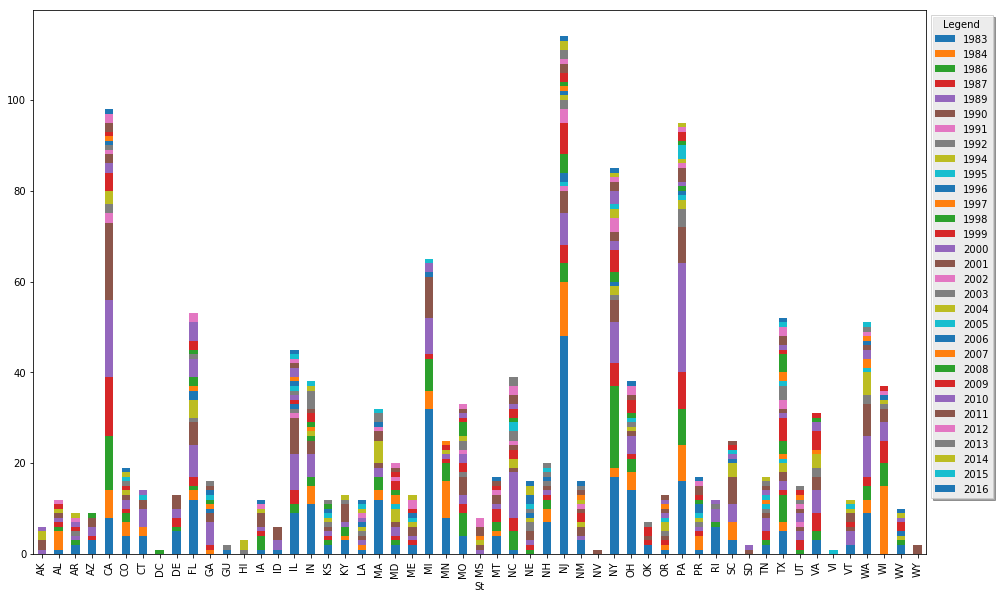

In [10]:
stateYear = pd.crosstab(sf['St'], sf['Year'])
# stateYear.head()
stateYear.plot(kind="bar", stacked=True, figsize=(16,10))
plt.legend(bbox_to_anchor=(1,1),
           ncol=1, shadow=True, title="Legend", fancybox=False)
plt.show()

## merge superfund and census 2015 data

In [11]:
sfcensus = sf.merge(census_pd, how="left", left_on="Zip", right_on="zip code tabulation area")
# sfcensus.head()

## Population segment analysis

In [111]:
# "B02001_002E" White alone
# "B02001_003E" Black alone
# "B02001_004E" American Indian or Alaskan Native Alone
# "B02001_005E" Asian alone
# "B02001_006E" Native Hawaiian and Other Pacific Islander Alone
# "B02001_008E" Two or more races
# "B03001_003E" Hispanic Origin

popList = ("B02001_002E","B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E")

nationalPopCount = []
for p in popList:
    nationalPopCount.append(pd.to_numeric(census_pd[p]).sum())
    
sfPopCount = []
for p in popList:
    sfPopCount.append(pd.to_numeric(sfcensus[p]).sum())

popLabels = ["White Alone", "Black Alone","American Indian or Alaskan Native Alone","American Indian or Alaskan Native Alone","Asian Alone","Native Hawaiian and Other Pacific Islander Alone","Two or more races","Hispanic Origin"]


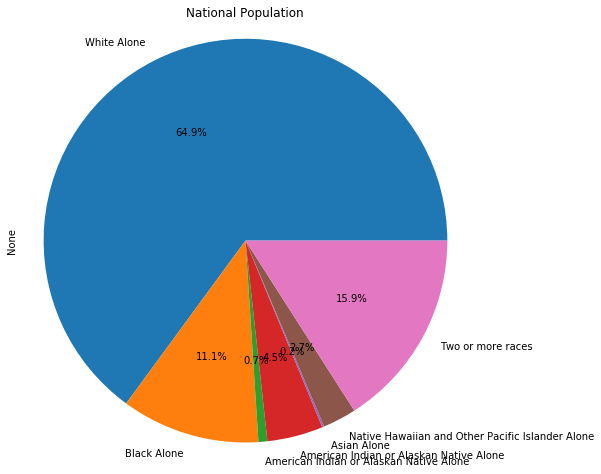

In [112]:
nationalPopSeries = pd.Series(nationalPopCount)
nationalPopSeries.plot(kind="pie", labels=popLabels, autopct="%1.1f%%", figsize=(8,8), title="National Population")
plt.axis("equal")
plt.show()

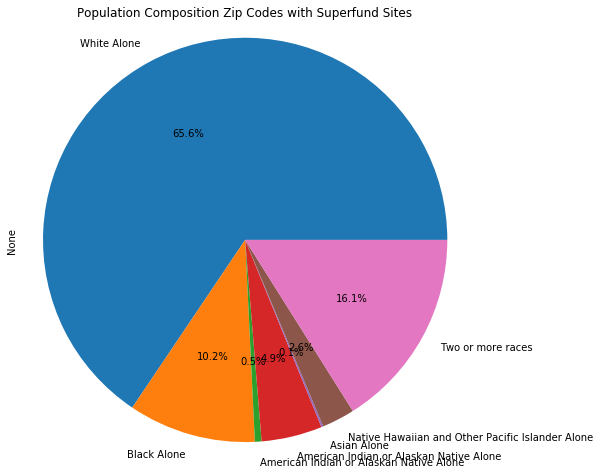

In [113]:
sfPopSeries = pd.Series(sfPopCount)
sfPopSeries.plot(kind="pie", labels=popLabels, autopct="%1.1f%%", figsize=(8,8), title="Population Composition Zip Codes with Superfund Sites")
plt.axis("equal")
plt.show()